In [8]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
args = {}
args['dim_h'] = 30            # factor controlling size of hidden layers
args['n_channel'] = 1         # number of channels in the input data (MNIST is 1, aka greyscale)
args['n_z'] = 10              # number of dimensions in latent space. 
args['sigma'] = 1.0           # variance in n_z
args['lambda'] = 10           # hyper param for weight of discriminator loss
args['lr'] = 0.0002           # learning rate for Adam optimizer
args['epochs'] = 5           # how many epochs to run for
args['batch_size'] = 256      # batch size for SGD

In [10]:
## load MNIST data train and test sets
trainset = datasets.MNIST(
    root='./data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

testset = datasets.MNIST(
    root='./data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = DataLoader(
    dataset=trainset,
    batch_size=args['batch_size'],
    shuffle=True
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=args['batch_size'],
    shuffle=False
)

## Try out the vanilla autoencoder 

In [11]:
## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [12]:
# instantiate models, and set to train mode
encoder, decoder = Encoder(args), Decoder(args)

# specify loss (mean squared error of image reconstruction)
criterion = nn.MSELoss()

# use the Adam optimizer, it's always a good choice
enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)

In [ ]:
for epoch in range(args['epochs']):
    for images, _ in tqdm(train_loader):
        encoder.train()
        decoder.train()
        
        encoder.zero_grad()
        decoder.zero_grad()
        batch_size = images.size()[0]

        z_hat = encoder(images)
        x_hat = decoder(z_hat)
        train_recon_loss = criterion(x_hat, images)

        train_recon_loss.backward()
        
        enc_optim.step()
        dec_optim.step()
        
    # Run validation set
    for images, _ in tqdm(test_loader):
        encoder.eval()
        decoder.eval()
        z_hat = encoder(images)
        x_hat = decoder(z_hat)
        test_recon_loss = criterion(x_hat, images)
    
    save_path = './save/AE_{}-epoch_{}.pth'
    torch.save(encoder.state_dict(), save_path.format('encoder', epoch))
    torch.save(decoder.state_dict(), save_path.format('decoder', epoch))
        
    print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {}\n\t\t\tTest Reconstruction Loss: {}".format(
        epoch + 1, 
        args['epochs'], 
        train_recon_loss.data.item(),
        test_recon_loss.data.item()
    ))

## Let's look at some images

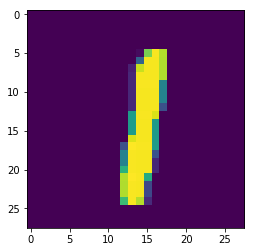

In [7]:
# look at an original image
plt.imshow(images[0,0].numpy())

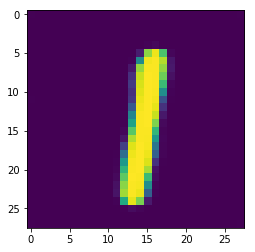

In [8]:
# run same image through autoencoder and take a peak
z_reps = encoder(images)
decoded_images = decoder(z_reps)

plt.imshow(decoded_images[0,0].detach().numpy())

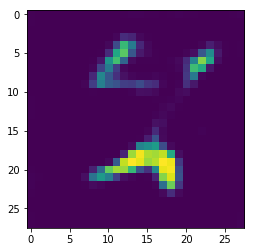

In [9]:
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

plt.imshow(rand_decoded_images[0,0].detach().numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa90f6bd9e8>,
      dtype=object)

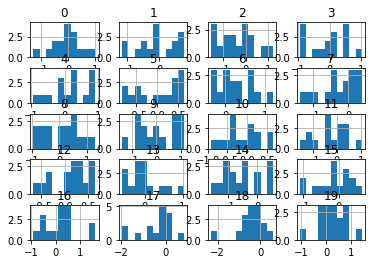

In [11]:
pd.DataFrame(z_reps.detach().numpy()).hist()

## WAE-GAN!

In [14]:
# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x
    
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [15]:
# instantiate discriminator model, and restart encoder and decoder, for fairness. Set to train mode, etc
encoder, decoder, discriminator = Encoder(args), Decoder(args), Discriminator(args)

enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])
dis_optim = torch.optim.Adam(discriminator.parameters(), lr = args['lr'])

enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)
dis_scheduler = torch.optim.lr_scheduler.StepLR(dis_optim, step_size=30, gamma=0.5)

In [ ]:
# one and -one allow us to control descending / ascending gradient descent
one = torch.Tensor([1])

log = {
    'd_z_loss': [],
    'd_z_hat_loss': [],
    'd_loss': [],
    'train_recon_loss': []
}

for epoch in range(args['epochs']):
    
    # train for one epoch -- set nets to train mode
    encoder.train()
    decoder.train()
    discriminator.train()
    
    for images, _ in tqdm(train_loader):
        # zero gradients for each batch
        encoder.zero_grad()
        decoder.zero_grad()
        discriminator.zero_grad()

        # ======== Train Discriminator ======== #
        
        # freeze auto encoder params
        frozen_params(decoder)
        frozen_params(encoder)
        
        # free discriminator params
        free_params(discriminator)

        # run discriminator against randn draws
        z = torch.randn(images.size()[0], args['n_z']) * args['sigma']
        d_z = discriminator(z)

        # run discriminator against encoder z's
        z_hat = encoder(images)
        d_z_hat = discriminator(z_hat)

        # formula for ascending the descriminator -- -one reverses the direction of the gradient.
        d_z_loss = torch.log(d_z).mean()
        
        d_z_hat_loss = torch.log(1 - d_z_hat).mean()
        
        d_z_loss.backward(-one)
        d_z_hat_loss.backward(-one)

        dis_optim.step()

        # ======== Train Generator ======== #

        # flip which networks are frozen, which are not
        free_params(decoder)
        free_params(encoder)
        frozen_params(discriminator)

        batch_size = images.size()[0]

        # run images
        z_hat = encoder(images)
        x_hat = decoder(z_hat)
        
        # discriminate latents
        d_z_hat = discriminator(encoder(Variable(images.data)))

        # calculate reconstruction loss
        train_recon_loss = criterion(x_hat, images)
        
        # calculate discriminator loss
        d_loss = args['lambda'] * (torch.log(d_z_hat)).mean()

        train_recon_loss.backward(one)
        d_loss.backward(-one)

        enc_optim.step()
        dec_optim.step()

        # capture losses of interest
        log['d_z_loss'].append(d_z_loss.data.item())
        log['d_z_hat_loss'].append(d_z_hat_loss.data.item())
        log['d_loss'].append(d_loss.data.item())
        log['train_recon_loss'].append(train_recon_loss.data.item())
    
    # test on test set
    encoder.eval()
    decoder.eval()
    for images, _ in tqdm(test_loader):
        z_hat = encoder(images)
        x_hat = decoder(z_hat)
        test_recon_loss = criterion(x_hat, images)
    
    save_path = './save/WAEgan_{}-epoch_{}.pth'
    torch.save(encoder.state_dict(), save_path.format('encoder', epoch))
    torch.save(decoder.state_dict(), save_path.format('decoder', epoch))
    torch.save(discriminator.state_dict(), save_path.format('discriminator', epoch))
    
    # print stats after each epoch
    print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {} d loss: {}, \n\t\t\tTest Reconstruction Loss:{}".format(
        epoch + 1, 
        args['epochs'], 
        train_recon_loss.data.item(),
        d_loss.data.item(),
        test_recon_loss.data.item()
    ))

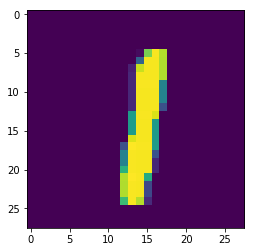

In [129]:
# look at an original image
plt.imshow(images[0,0].numpy())

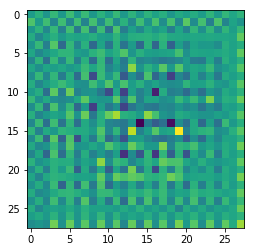

In [130]:
# run same image through autoencoder and take a peak
z_reps = encoder(images)
decoded_images = decoder(z_reps)

plt.imshow(decoded_images[0,0].detach().numpy())

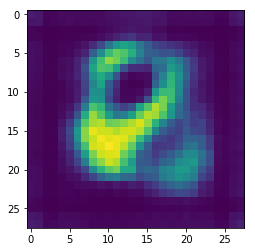

In [124]:
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

plt.imshow(rand_decoded_images[0,0].detach().numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8e8b20f28>,
      dtype=object)

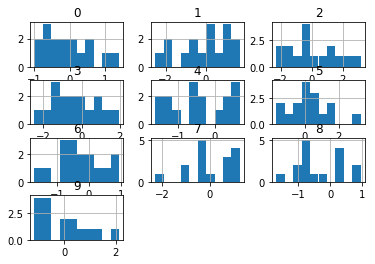

In [126]:
fake_z_reps = torch.randn_like(z_reps)
pd.DataFrame(fake_z_reps.numpy()).hist()

Text(0.5,1,'lambda = 1')

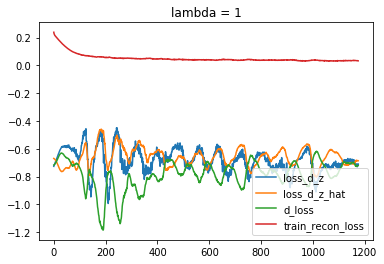

In [75]:
l1 = pd.DataFrame.from_dict(log)
ax = l1.plot()
ax.set_title('lambda = 1')

In [ ]:
df = pd.DataFrame.from_dict(log)
df.to_csv('wae_gan.log')